#Installing Libraries

In [11]:
pip install -U sentence-transformers

#Importing Libraries

In [26]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, XLNetTokenizer, XLNetModel, GPT2Tokenizer, GPT2Model
import torch
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

#Dataset Loading and General Preprocessing

In [13]:
# Load the datasets
# Code testing was done in Google Colab, hence the path /content/dataset
cali_df = pd.read_csv('/content/Cali_cleaned_penal_codes.csv')
nyc_df = pd.read_csv('/content/NYC_cleaned_penal_codes.csv')

# Preprocess and extract laws as lists of strings
cali_laws = cali_df['citation'].astype(str).tolist()
ny_laws = nyc_df['citation'].astype(str).tolist()

#TF-IDF Similarity Calculation

##Whole Law Dataset Comparison

In [29]:
# TF-IDF Whole Comparison
cali_combined = ' '.join(cali_laws)
nyc_combined = ' '.join(ny_laws)

vectorizer_combined = TfidfVectorizer()
tfidf_combined = vectorizer_combined.fit_transform([cali_combined, nyc_combined])
cosine_similarity_combined = cosine_similarity(tfidf_combined[0:1], tfidf_combined[1:2])

avg_similarity_tfidf_whole = cosine_similarity_combined[0][0]

print(f'Average Similarity Score (TF-IDF Whole):  {avg_similarity_tfidf_whole}')


Average Similarity Score (TF-IDF Whole):  0.8969831983195962


##Law by Law Comparison

In [17]:
# TF-IDF Law by Law Comparison
vectorizer = TfidfVectorizer()
all_laws_tfidf = vectorizer.fit_transform(cali_laws + ny_laws)

cali_tfidf = all_laws_tfidf[:len(cali_laws)]
ny_tfidf = all_laws_tfidf[len(cali_laws):]

similarity_scores_tfidf = []
for ny_law_tfidf in ny_tfidf:
    law_scores_tfidf = cosine_similarity(ny_law_tfidf, cali_tfidf)[0]
    avg_score_tfidf = np.mean(law_scores_tfidf)
    similarity_scores_tfidf.append(avg_score_tfidf)

# Similarity Calculation for TF-IDF (Law by Law)
avg_similarity_tfidf = np.mean(similarity_scores_tfidf)
print(f'Average Similarity Score (TF-IDF Law by Law): {avg_similarity_tfidf}')

Average Similarity Score (TF-IDF Law by Law): 0.09475459861894778


#GPT-2 Embeddings and Similarity Calculation

In [21]:
# GPT-2 Embeddings
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt2 = GPT2Model.from_pretrained('gpt2')
model_gpt2.to('cuda')
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

def encode_with_gpt2(texts, tokenizer, model, batch_size=8):
    model.eval()
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

cali_embeddings_gpt2 = encode_with_gpt2(cali_laws, tokenizer_gpt2, model_gpt2)
ny_embeddings_gpt2 = encode_with_gpt2(ny_laws, tokenizer_gpt2, model_gpt2)

# Similarity Calculation for GPT-2
similarity_scores_gpt2 = cosine_similarity(ny_embeddings_gpt2, cali_embeddings_gpt2)
avg_similarity_gpt2 = np.mean(similarity_scores_gpt2)
print(f'Average Similarity Score (GPT-2): {avg_similarity_gpt2}')


Average Similarity Score (GPT-2): 0.9833701848983765


#RoBERTa Embeddings and Similarity Calculation

In [19]:
# RoBERTa Embeddings
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
model_roberta = RobertaModel.from_pretrained('roberta-base')
model_roberta.to('cuda')

def encode_with_roberta(texts, tokenizer, model, batch_size=8):
    model.eval()
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

cali_embeddings_roberta = encode_with_roberta(cali_laws, tokenizer_roberta, model_roberta)
ny_embeddings_roberta = encode_with_roberta(ny_laws, tokenizer_roberta, model_roberta)

# Similarity Calculation for RoBERTa
similarity_scores_roberta = cosine_similarity(ny_embeddings_roberta, cali_embeddings_roberta)
avg_similarity_roberta = np.mean(similarity_scores_roberta)
print(f'Average Similarity Score (RoBERTa): {avg_similarity_roberta}')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average Similarity Score (RoBERTa): 0.9437848329544067


#BERT Embeddings and Similarity Calculation

In [18]:
# BERT Embeddings
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')
model_bert.to('cuda')

def encode_with_bert(texts, tokenizer, model, batch_size=8):
    model.eval()
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

cali_embeddings_bert = encode_with_bert(cali_laws, tokenizer_bert, model_bert)
ny_embeddings_bert = encode_with_bert(ny_laws, tokenizer_bert, model_bert)

# Similarity Calculation for BERT
similarity_scores_bert = cosine_similarity(ny_embeddings_bert, cali_embeddings_bert)
avg_similarity_bert = np.mean(similarity_scores_bert)
print(f'Average Similarity Score (BERT): {avg_similarity_bert}')

Average Similarity Score (BERT): 0.7827407121658325


#XLNet Embeddings and Similarity Calculation

In [20]:
# XLNet Embeddings
tokenizer_xlnet = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model_xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
model_xlnet.to('cuda')

def encode_with_xlnet(texts, tokenizer, model, batch_size=8):
    model.eval()
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

cali_embeddings_xlnet = encode_with_xlnet(cali_laws, tokenizer_xlnet, model_xlnet)
ny_embeddings_xlnet = encode_with_xlnet(ny_laws, tokenizer_xlnet, model_xlnet)

# Similarity Calculation for XLNet
similarity_scores_xlnet = cosine_similarity(ny_embeddings_xlnet, cali_embeddings_xlnet)
avg_similarity_xlnet = np.mean(similarity_scores_xlnet)
print(f'Average Similarity Score (XLNet): {avg_similarity_xlnet}')

Average Similarity Score (XLNet): 0.765640377998352


#Visualisation of Output

In [27]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

In [35]:
# Dictionary of model names and their average similarity scores
similarity_scores = {
    'TF-IDF (Whole)': avg_similarity_tfidf_whole,  # From whole dataset document comparison
    'TF-IDF (Avg)': avg_similarity_tfidf,  # From average individual law comparisons
    'GPT-2': avg_similarity_gpt2,
    'RoBERTa': avg_similarity_roberta,
    'BERT': avg_similarity_bert,
    'XLNet': avg_similarity_xlnet,
}

# Convert to DataFrame for easier plotting
scores_df = pd.DataFrame(list(similarity_scores.items()), columns=['Model', 'Average Similarity Score'])

<ipython-input-36-8993b5008b3e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=scores_df, x='Model', y='Average Similarity Score', palette='coolwarm')


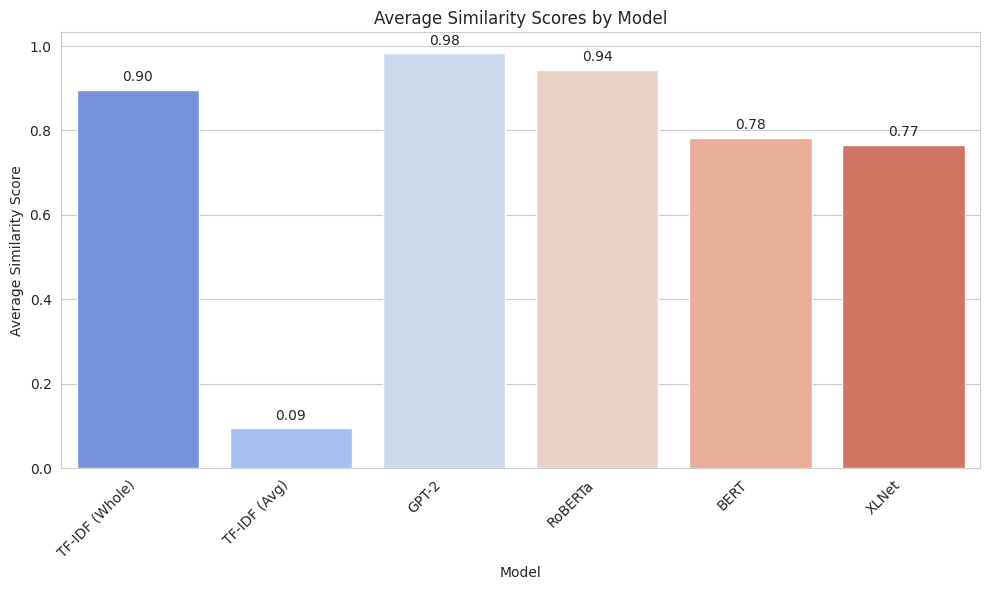

In [36]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=scores_df, x='Model', y='Average Similarity Score', palette='coolwarm')
plt.title('Average Similarity Scores by Model')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Similarity Score')
plt.xlabel('Model')

# Annotate the bars with the actual score values
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()


#Analysis

### High Similarity Scores (TF-IDF Whole, GPT-2, RoBERTa):
- **TF-IDF (Whole)**: The high score indicates that when considered as a single corpus, the legal codes of California and New York share a significant amount of terminology and phrasing. This is common in legal documents where certain phrases, definitions, and structures recur frequently.
- **GPT-2**: GPT-2's high score suggests that the model, which is adept at generating coherent text, is also recognizing the structured and formulaic nature of legal language. This score may reflect GPT-2's focus on stylistic coherence over the semantic content, suggesting that the legal texts have similar styles or use similar "boilerplate" language.
- **RoBERTa**: As an optimized version of BERT, RoBERTa's high similarity score can imply that the model is effectively capturing both the shared legal terminology and the contextual semantics within the legal codes, possibly indicating a deep understanding of the texts' similarities.

### Moderate Similarity Scores (BERT, XLNet):
- **BERT and XLNet**: These models offer a nuanced understanding of the context within texts, potentially identifying both shared and distinct elements within the legal codes. Their moderate scores suggest that while there's considerable overlap in the way legal concepts are expressed, there are also significant differences between the states' laws that the models are recognizing.

### Low Similarity Score (TF-IDF Average):
- **TF-IDF (Avg)**: The low score from the average of individual law comparisons using TF-IDF indicates that when each law is considered on its own, there are significant differences in the specific language and content of the laws. This score likely reflects the unique aspects of each state's legal statutes and the variability across individual documents.
### Insights and Conclusions :
The variability in scores across models underscores the complexity of measuring textual similarity, especially in specialized domains like legal texts. The scores reflect the interplay between shared legal language and jurisdiction-specific legal stipulations:

- **Jurisdiction-Specific Content**: The unique legal stipulations and frameworks that differentiate California's and New York's legal systems are likely contributing to the differences captured by models that focus on semantic content, like BERT and XLNet.
  
- **Model Sensitivities**: Each model's architectural sensitivities to context, word usage, and language patterns influence their performance. Transformer models like BERT and XLNet, designed for nuanced contextual understanding, appear to identify a moderate level of similarity, recognizing overlaps and distinctions in legal language.

- **Impact of Aggregation**: Aggregating all laws into a single document for TF-IDF comparison tends to mask individual differences, hence the high similarity score. It emphasizes the global presence of legal terminology but loses the granularity of law-specific language nuances.

- **Stylistic vs. Semantic Similarity**: GPT-2's exceptionally high similarity score might suggest that it is capturing stylistic coherence rather than deep semantic parallels, which could inflate similarity scores if the emphasis is on the formal structure rather than on varied legal content.

- **Granularity and Context**: The lower similarity scores from TF-IDF's law-by-law comparison illustrate the importance of granularity in legal text analysis. A detailed approach reveals the diversity and specificity of legal provisions across jurisdictions, resulting in a more conservative similarity estimate.

- **Inconsistent Dataset**: Our team struggled finding a good dataset till the end and we ended up making our own using a scraper from Justia website but the datasets not being exactly the same in terms of number of laws, the laws we scrapped from California Penal Laws are much higher in number than NY Penal laws, this is also affecting the avg. scores of models after the comparison as it is comparing each and every law with each other.

Overall, these results suggest that the choice of model and methodology significantly affects the similarity scores obtained in textual analysis. The findings highlight a trade-off between capturing stylistic/formal similarities and delving into the semantic intricacies of legal language. For legal texts, where precision and context are paramount, models like BERT and XLNet may strike a better balance between recognizing overarching legal language patterns and discerning detailed statutory differences. While RoBERTa might simply be a better model compared to BERT and XLNet as it is trained on a much bigger dataset compared to BERT but we are unsure if that's the reason for the high similarity score or if its facing the same issue as GPT-2 of not considering the semantics of the laws.